<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/%EB%AA%A8%EC%9D%984.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 한글 폰트 설치 (나눔고딕 예시)
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 기계학습 (60점)

In [3]:
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 출생데이터
- 출처 : https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240
- 자료 이용 주의사항 (국가통계 자료제공 규정 제 17조 제 1항)     
  ○ 개별 자료에 의거 알게 된 사항에 대한 제공 및 누설 금지    
  ○ 자료 이용의 정확한 목적 명시 및 작성 목적 이외의 사용 금지     
  ○ 제공 자료의 활용이 끝난 후 즉시 파기    
  ○ 자료의 무단 공유 · 복제 금지     
  ○ 올바른 분석기법 사용 및 통계적 오차를 적정수준으로 유지하도록 노력     

- 본 모의고사는 MDIS 담당부서 문의 후 자료 이용 동의 받고 사용

데이터 경로
- ./data/
    - 2019.csv ~ 2022.csv : 년도별 출생관련 데이터
    - index.csv : 데이터 컬럼 상세
        - 항목명 : 컬럼
            - 항목명 컬럼의 결측치는 값이 존재하는 상위 데이터와 일치한다.
            - ex. 1행의 항목명은 '출생자주소지_행정구역시도코드' , 18행의 항목명은 성별코드
        - 코드 : 데이터
        - 코드의미 및 단위 : 코드의 의미

In [5]:
import pandas as pd
pd.set_option('display.max_columns',100)


df =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/2019.csv')
display(df.head())
idx = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/index.csv')
idx.head()

,연도,신고연도,신고월,신고일,출생자주소지_행정구역시도코드,성별코드,결혼중외의자녀여부코드,출생연도,출생월,출생장소코드,부_직업분류코드,부_교육정도코드,부_각세연령,모_직업분류코드,모_교육정도코드,모_각세연령,실제결혼연도,실제결혼월,임신주수,다태아분류코드,다태아출산순위코드,출생아체중,모총출생아수코드,모생존아수코드,부모동거기간,부_국적구분코드,부_국적코드,모_국적구분코드,모_국적코드
0,2019,2019,1,1,31,1,Y,2019,1,2,99,9,999,99,9,36,9999,99,20,1,1,0.453,2,99,999,1,NaN,3,9000.0
1,2019,2019,1,1,33,1,9,2019,1,2,99,9,999,99,9,27,9999,99,39,9,9,3.090,99,99,999,9,NaN,1,NaN
2,2019,2019,1,2,11,1,Y,2019,1,2,1,5,33,2,5,32,2014,10,39,1,1,3.380,2,2,4,1,NaN,1,NaN
3,2019,2019,1,2,11,1,Y,2019,1,2,3,5,33,3,5,33,2014,4,39,1,1,3.060,2,2,4,1,NaN,1,NaN
4,2019,2019,1,2,11,1,Y,2019,1,2,5,3,34,13,4,34,2017,12,35,2,1,2.645,1,1,1,1,NaN,1,NaN


,항목명,코드,코드의미 및 단위
0,출생자주소지_행정구역시도코드,11,서울특별시
1,NaN,21,부산광역시
2,NaN,22,대구광역시
3,NaN,23,인천광역시
4,NaN,24,광주광역시


### 기계학습1
아래를 기준으로 데이터 전처리를 진행하라      
1. 년도별 출생 데이터를 하나의 데이터 프레임으로 합친다.     
2. 데이터 컬럼 상세 데이터를 바탕으로 출생 데이터의 값을 변환한다.
3. 변환한 데이터 컬럼 중 '미상'을 포함하는 행이 존재한다면 해당 행은 제거한다.    
4. 아래의 조건에 해당하는 각 컬럼의 값이 있다면 해당 행은 제거한다
    - 부_교육정도코드 : 학력없음    
    - 부_각세연령 : 999.0    
    - 모_교육정도코드 : 학력없음
    - 모_각세연령 :999.0
    - 실제결혼연도 : 9999.0
    - 실제결혼월 : 99.0
    - 부모동거기간 : 999
    - 모_각세연령 : 50세 이상
    - 임신주수 : 0
    - 출생아체중: 1kg 이하

결과예시
<img src="./data/1.png" style="width:10000px; float:left; ">

In [6]:
idx['항목명'] = idx['항목명'].fillna(method = 'ffill')

target_dic = {}
for name in idx['항목명'].unique() :
  target = idx[idx['항목명'] == name]

  dics = {}
  for key, value in target.iloc[:,1:].values :
    if key[0] == '0' :
      dics[str(int(key))] = value
    else :
      dics[str(key)] = value
  target_dic[name] = dics


/tmp/ipython-input-3955851727.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  idx['항목명'] = idx['항목명'].fillna(method = 'ffill')


In [7]:
# 데이터 타입 변경

def conver_str(x) :
  if pd.isna(x) :
    return np.nan
  elif isinstance(x, str) :
    return x
  else :
    return str(int(x))

# target_dic 매핑해주기
for col in df.columns :
  if col in target_dic.keys() :
    # 데이터 타입을 변경해주고,
    df[col] = df[col].map(conver_str)

    # targetdic 매핑
    df[col] = df[col].map(target_dic[col])

In [8]:
df1 = df.copy()

In [9]:
# 미상이 있는 데이터 찾기
# 데이터를 str로 바꿔서 미상이 있는 곳 어디든(.any()) , axis = 1

mask = df1.astype(str).apply(lambda x : x.str.contains('미상').any() , axis = 1)

# ~ mask : ~가 없는 데이터만
df2 =df1[~mask].reset_index(drop = True)
#df2.head(4)

In [10]:
# 제시된 조건의 데이터 제거
remove_dic = {
    '부_교육정도코드' : '학력없음',
    '부_각세연령' : 999.0,
    '모_교육정도코드' : '학력없음',
    '모_각세연령' :999.0,
    '실제결혼연도' : 9999.0,
    '실제결혼월' : 99.0,
    '부모동거기간' : 999,
    '임신주수' : 0
}

for key, value in remove_dic.items() :
  df2 = df2[df2[key] != value].reset_index(drop = True)

In [11]:
# 모_각세연령 50세 이상
df2 = df2.loc[df2['모_각세연령'] < 50].reset_index(drop = True)

# 출생아 체중 1kg이하
df2 = df2.loc[df2['출생아체중'] >1 ].reset_index(drop = True)

### 기계학습2
출생아체중을 중점으로 EDA를 실시하라 (시각화 포함)

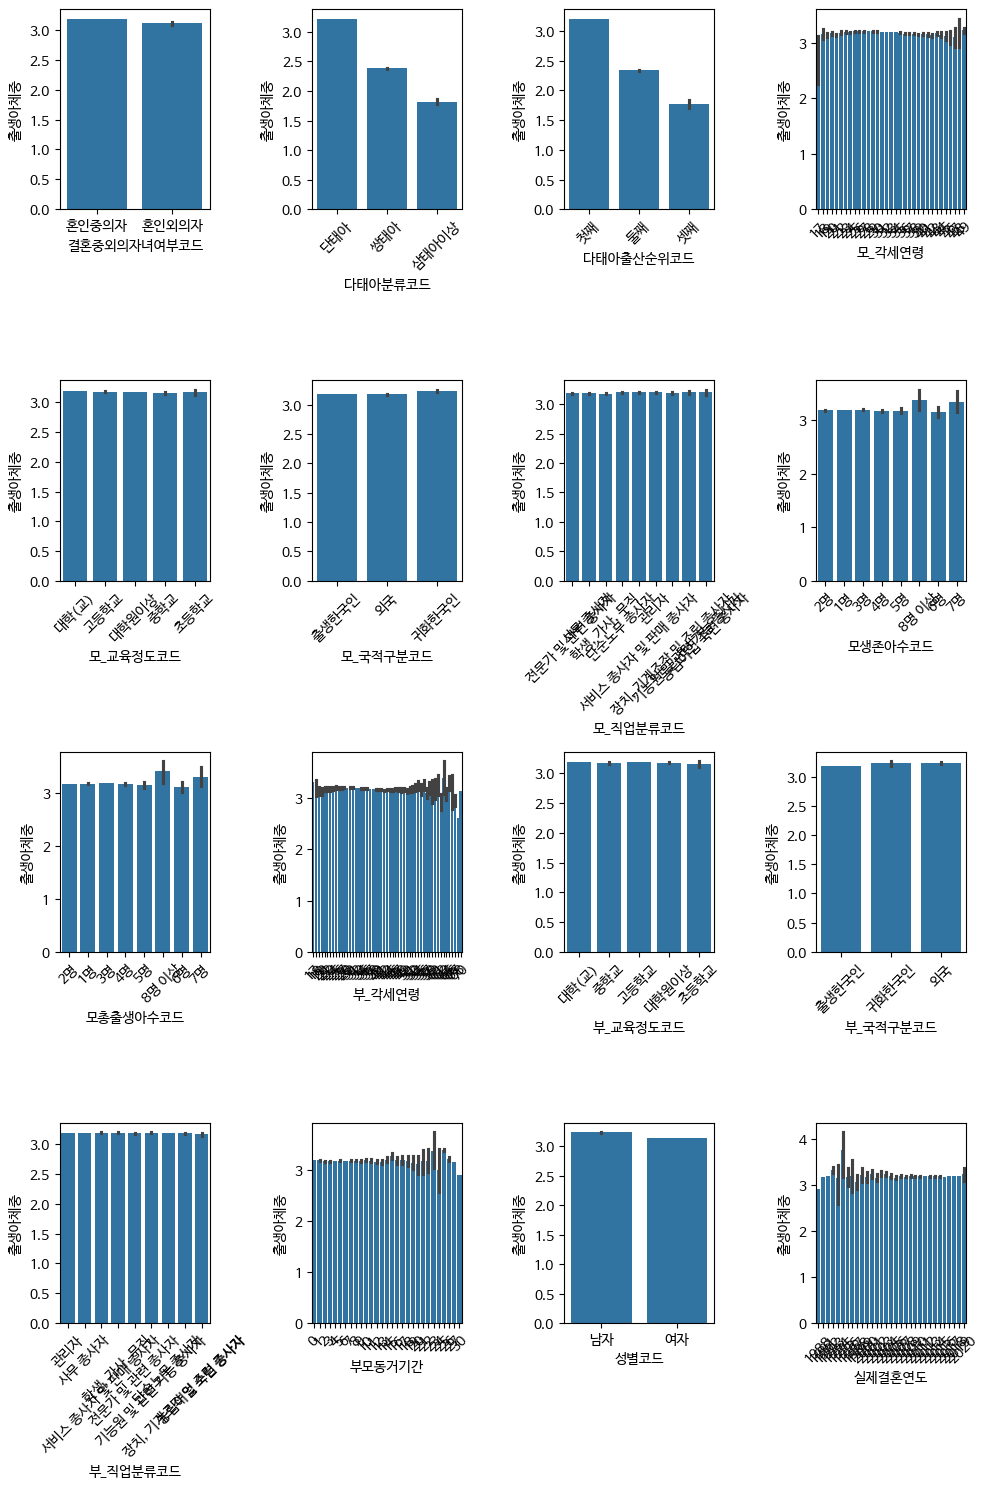

        Columns        P_value
0   결혼중외의자녀여부코드   6.656892e-09
1       다태아분류코드   0.000000e+00
2     다태아출산순위코드   0.000000e+00
3        모_각세연령   0.000000e+00
4      모_교육정도코드  2.402751e-202
5      모_국적구분코드   0.000000e+00
6      모_직업분류코드  2.346512e-102
7       모생존아수코드   0.000000e+00
8      모총출생아수코드   0.000000e+00
9        부_각세연령   0.000000e+00
10     부_교육정도코드  6.618683e-315
11     부_국적구분코드   0.000000e+00
12     부_직업분류코드  3.738258e-266
13       부모동거기간  1.563478e-279
14         성별코드   0.000000e+00
15       실제결혼연도  2.402570e-270


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind , f_oneway

cols  =['출생자주소지_행정구역시도코드', '성별코드', '결혼중외의자녀여부코드',
       '출생연도', '출생월', '출생장소코드', '부_직업분류코드', '부_교육정도코드', '부_각세연령', '모_직업분류코드',
       '모_교육정도코드', '모_각세연령', '실제결혼연도', '실제결혼월', '임신주수', '다태아분류코드', '다태아출산순위코드',
       '출생아체중', '모총출생아수코드', '모생존아수코드', '부모동거기간', '부_국적구분코드', '모_국적구분코드' ]

eda = df2[cols]


fig, axes = plt.subplots(4,4, figsize = (10, 15))
res =[]
for axes, col in zip(axes.flatten(), eda.columns.difference(['출생아체중'])) :

  if eda[col].nunique() == 2 :
    group = eda[col].unique()
    g1 = eda[eda[col] == group[0]]['출생아체중']
    g2 = eda[eda[col] == group[1]]['출생아체중']
    stat, p_val = ttest_ind(g1, g2)

    target = eda[[col , '출생아체중']]
    sns.barplot(x = target[col] , y = target['출생아체중'] , ax = axes)

  elif  eda[col].nunique() > 2 :
    g = [group['출생아체중'] for name, group in df.groupby(col)]
    stat, p_val = f_oneway(* g)

    target = eda[[col , '출생아체중']]
    sns.barplot(x = target[col] , y = target['출생아체중'] , ax = axes)
    axes.tick_params(axis='x', rotation=45)

  res.append({
        'Columns' : col,
        'P_value' : p_val
    })

plt.tight_layout()
plt.show()

print(pd.DataFrame(res))

### 기계학습3     
아래의 기준으로 추가적인 전처리를 실행하고 `출생아체중`이 각 컬럼들의 값에 따른 차이가 존재하는지 통계 검정을 실시하라
- 데이터 필터 : `신고월`이 2월이며 `신고일`이 10일 이하
- 컬럼제거 : 연도,신고연도,신고월,신고일, 출생자주소지_행정구역시도코드, 결혼중외의자녀여부코드,부_교육정도코드,모_직업분류코드,출생연도,출생월,출생장소코드,실제결혼연도,실제결혼월,모생존아수코드,부_국적코드,모_국적코드,모_국적구분코드,부_국적구분코드

In [13]:
string = '연도,신고연도,신고월,신고일, 출생자주소지_행정구역시도코드, 결혼중외의자녀여부코드,부_교육정도코드,모_직업분류코드,출생연도,출생월,출생장소코드,실제결혼연도,실제결혼월,모생존아수코드,부_국적코드,모_국적코드,모_국적구분코드,부_국적구분코드'
remove_cols = [x.strip() for x in string.split(',')]

df3 = df2[(df2['신고월'] ==2) & (df2['신고일'] <= 10)].reset_index(drop = True)
df3 = df3.drop(remove_cols, axis = 1)

In [14]:
from scipy.stats import ttest_ind, f_oneway, pearsonr

res = []
for col in df3.columns.difference(['출생아체중']) :
  way = None # Initialize way before the conditional statements

  if df3[col].dtype == 'object' and df3[col].nunique() == 2 :
    groups = df3[col].unique()
    g1 = df3[df3[col] == groups[0]]['출생아체중']
    g2 = df3[df3[col] == groups[1]]['출생아체중']

    stat, p_val = ttest_ind(g1, g2)
    way = 'T-Test'
    decision = '유의하다' if p_val < 0.05 else '유의하지않다.'

  elif df3[col].dtype == 'object' and df3[col].nunique() > 2  :
    g = [group['출생아체중'] for name, group in df3.groupby([col])]
    stat, p_val = f_oneway(* g)
    way = 'ANOVA'
    decision = '유의하다' if p_val < 0.05 else '유의하지않다.'

  elif df3[col].dtype != 'object' :
    stat, p_val = pearsonr(df3[col], df3['출생아체중'])
    way = 'Correlation'
    decision = '유의하다' if p_val < 0.05 else '유의하지않다.'

  res.append({
      'Columns' : col,
      'p_value' : p_val ,
      'way' : way,
      'decision' : decision
  })

result = pd.DataFrame(res)
result

,Columns,p_value,way,decision
0,다태아분류코드,5.613862e-161,ANOVA,유의하다
1,다태아출산순위코드,7.883439e-77,ANOVA,유의하다
2,모_각세연령,7.260205e-02,Correlation,유의하지않다.
3,모_교육정도코드,1.470248e-01,ANOVA,유의하지않다.
4,모총출생아수코드,4.659049e-01,ANOVA,유의하지않다.
5,부_각세연령,4.622751e-03,Correlation,유의하다
6,부_직업분류코드,1.099635e-01,ANOVA,유의하지않다.
7,부모동거기간,5.970592e-01,Correlation,유의하지않다.
8,성별코드,3.919234e-12,T-Test,유의하다
9,임신주수,0.000000e+00,Correlation,유의하다


### 기계학습4     
3에서 전처리한 데이터를 바탕으로 출생아 체중을 예측하는 회귀 모델을 만들려고한다. 아래의 조건에 맞게 모델링을 진행하고 평가하라
- 성별코드 기준으로 층화추출 진행 (학습데이터 70%, 평가 데이터 30%)
- 평가기준 rmse
- 랜덤포레스트, 다중선형회귀 모델로 진행

,0,1
0,RF,0.381244
1,LR,0.371785


/tmp/ipython-input-564873394.py:66: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


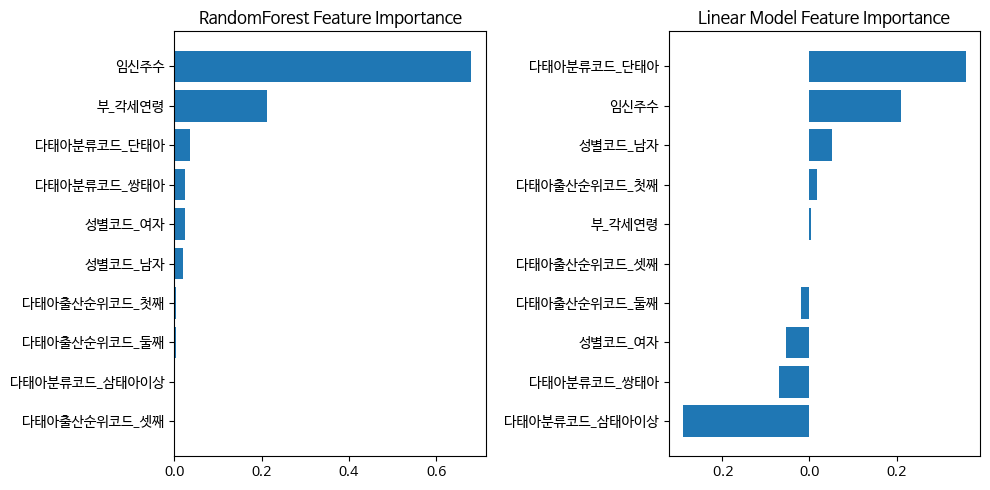

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

model_cols = result[result['decision'] == '유의하다']['Columns'].tolist()

x_df = df3[model_cols]

cleand_x_df = pd.DataFrame()
for col in x_df.columns :
  if x_df[col].dtype != 'object' :
    ss = StandardScaler()
    cleand_x_df[col] = ss.fit_transform(x_df[[col]]).flatten()

  else :
    dummies = pd.get_dummies(x_df[col], prefix = col, dtype = int)
    for d_col in dummies.columns :
      cleand_x_df[d_col] = dummies[d_col]


# X준비 데이터
X = cleand_x_df.copy()
y = df3['출생아체중']

X_train, X_test, y_train, y_test = train_test_split(
                                                        X, y,
                                                        test_size=0.3,
                                                        stratify=df3['성별코드'],  # 층화 기준
                                                        random_state=42
                                                    )

def eval_model (name, model) :
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  RMSE = np.sqrt(mean_squared_error(y_test, pred))

  return name, RMSE

res = []
model_lst = []
for name, model in [['RF', RandomForestRegressor()] , ['LR', LinearRegression()]] :
  name, RMSE = eval_model(name, model)
  model_lst.append([name, model])
  res.append([name, RMSE])

display(pd.DataFrame(res))

fig, axes = plt.subplots(1,2, figsize = (10, 5))
for name, model in model_lst :
  if name == 'RF' :
    imp = model.feature_importances_
    name = X.columns
    imp_series = pd.Series(imp, index = name).sort_values()
    axes[0].barh(imp_series.index, imp_series.values)
    axes[0].set_title('RandomForest Feature Importance')

  elif name == 'LR' :
    imp = model.coef_
    name = model.feature_names_in_
    imp_series = pd.Series(imp, index = name).sort_values()
    axes[1].barh(imp_series.index, imp_series.values)
    axes[1].set_title('Linear Model Feature Importance')

plt.tight_layout()
plt.show()


### 서울 지하철 일별 승하차 인원 데이터
출처 :https://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do 후처리     
data_path = './data/subway.csv'


In [16]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET4/data/subway.csv')
df.head()

,날짜,역번호,역명,구분,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,13~14,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,호선
0,2016-01-01,150,서울역(150),승차,469,339,584,1144,1723,2087,2983,3527,3386,2612,3639,3554,3200,3076,2519,2281,2398,2056,996,58,1
1,2016-01-01,150,서울역(150),하차,342,1637,1753,1856,2438,2425,2548,2718,2973,2921,3341,3108,2656,2134,1859,1394,1344,1056,612,222,1
2,2016-01-01,151,시청(151),승차,103,127,110,191,298,582,700,604,731,900,1069,1339,1458,1499,1383,1284,1198,675,375,9,1
3,2016-01-01,151,시청(151),하차,68,306,554,939,689,665,884,956,1084,1216,1033,1035,951,792,618,402,309,192,114,34,1
4,2016-01-01,152,종각(152),승차,702,341,234,296,335,419,733,865,991,1300,1772,2175,2580,2627,2302,2315,2365,2140,1117,51,1


### 기계학습5    
아래의 기준으로 전처리를 진행하라     
1. 일자마다 노선별로 각 시간대의 모든역에서의 이용 승객 수를 승차,하차 각각 더한다.
    - 날짜,호선,구분,모든시간대 컬럼만 남아있어야한다. (4386 rows × 23 columns)
2. 아래의 조건으로 새로운 데이터프레임을 생성한다. 일자마다 호선별로 각 시간대의 승차 / 하차 비율을 구하여 _ratio 를 붙혀 새로운 컬럼을 만든다.
    - 2016-01-01, 1호선의 `05 ~ 06(승차) /05 ~ 06(하차)` :
        - 컬럼 : `05~06_ratio`
        - 값 : 3.5696 (2613/732)
3. 해당 일자가 평일(0)인지 주말(1)인지 구분하는 'weekend' 컬럼을 추가한다

In [17]:
df.head(3)

,날짜,역번호,역명,구분,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,13~14,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,호선
0,2016-01-01,150,서울역(150),승차,469,339,584,1144,1723,2087,2983,3527,3386,2612,3639,3554,3200,3076,2519,2281,2398,2056,996,58,1
1,2016-01-01,150,서울역(150),하차,342,1637,1753,1856,2438,2425,2548,2718,2973,2921,3341,3108,2656,2134,1859,1394,1344,1056,612,222,1
2,2016-01-01,151,시청(151),승차,103,127,110,191,298,582,700,604,731,900,1069,1339,1458,1499,1383,1284,1198,675,375,9,1


In [18]:
df = df.drop(columns = ['역명'], axis = 1 )

In [19]:
melt_df = df.melt(id_vars= ['날짜', '역번호' ,'호선','구분'] , var_name = '시간' , value_name = '인원수' )
melt_df.head(4)

,날짜,역번호,호선,구분,시간,인원수
0,2016-01-01,150,1,승차,05~06,469
1,2016-01-01,150,1,하차,05~06,342
2,2016-01-01,151,1,승차,05~06,103
3,2016-01-01,151,1,하차,05~06,68


In [29]:
pivot_df  = melt_df.pivot_table(index = ['날짜','호선','시간'] , columns = ['구분'] , values = ['인원수'] ).reset_index()
pivot_df.columns = ['날짜', '호선', '시간', '인원수_승차', '인원수_하차']

pivot_df['ratio'] = pivot_df['인원수_승차'] / pivot_df['인원수_하차']
pivot_df.head(4)

,날짜,호선,시간,인원수_승차,인원수_하차,ratio
0,2016-01-01,1,05~06,261.3,73.2,3.569672
1,2016-01-01,1,06~07,205.5,325.3,0.631725
2,2016-01-01,1,07~08,211.5,385.5,0.548638
3,2016-01-01,1,08~09,338.2,531.1,0.636792


In [35]:
f_df = pivot_df.pivot_table(index = ['날짜','호선'] , columns = '시간', values = 'ratio').reset_index()
# index 이름 삭제하기
f_df.columns.name = None
f_df.head(4)

,날짜,호선,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,13~14,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~
0,2016-01-01,1,3.569672,0.631725,0.548638,0.636792,0.775704,0.808009,0.831517,0.770004,0.766533,0.801024,1.045816,1.277316,1.353502,1.395663,1.458895,1.772087,1.944890,1.846209,1.311940,0.183721
1,2016-01-01,2,5.173876,1.198138,1.191171,1.100397,0.981767,1.037915,0.989607,0.968656,0.933618,0.944873,0.930663,0.979071,0.966366,0.934122,0.958119,1.079435,1.189924,1.170612,0.760431,0.004000
2,2016-01-01,3,3.814969,0.630485,0.782427,0.833200,0.759934,0.787604,0.828105,0.863113,0.862567,0.884181,1.018443,1.102005,1.154037,1.070333,1.050004,1.114768,1.227530,1.097164,0.506338,0.011957
3,2016-01-02,1,2.398010,0.591137,0.499784,0.582205,0.590733,0.642208,0.663121,0.686435,0.724733,0.818402,1.118137,1.348625,1.417669,1.380289,1.613574,2.016819,2.268172,2.443082,1.543539,0.177613


In [44]:
# 해당 일자가 평일(0)인지 주말(1)인지 구분하는 'weekend' 컬럼
f_df['날짜'] = pd.to_datetime(f_df['날짜'])
f_df['weekend'] = f_df['날짜'].apply(lambda x  : 1 if  x.weekday() in [5,6] else 0)

### 기계학습6     
데이터 EDA를 진행하라. (시각화 포함)

In [45]:
f_df.head()

,날짜,호선,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,13~14,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,weekend
0,2016-01-01,1,3.569672,0.631725,0.548638,0.636792,0.775704,0.808009,0.831517,0.770004,0.766533,0.801024,1.045816,1.277316,1.353502,1.395663,1.458895,1.772087,1.944890,1.846209,1.311940,0.183721,0
1,2016-01-01,2,5.173876,1.198138,1.191171,1.100397,0.981767,1.037915,0.989607,0.968656,0.933618,0.944873,0.930663,0.979071,0.966366,0.934122,0.958119,1.079435,1.189924,1.170612,0.760431,0.004000,0
2,2016-01-01,3,3.814969,0.630485,0.782427,0.833200,0.759934,0.787604,0.828105,0.863113,0.862567,0.884181,1.018443,1.102005,1.154037,1.070333,1.050004,1.114768,1.227530,1.097164,0.506338,0.011957,0
3,2016-01-02,1,2.398010,0.591137,0.499784,0.582205,0.590733,0.642208,0.663121,0.686435,0.724733,0.818402,1.118137,1.348625,1.417669,1.380289,1.613574,2.016819,2.268172,2.443082,1.543539,0.177613,1
4,2016-01-02,2,3.903804,0.992869,1.161872,1.023701,0.870228,0.914519,0.916810,0.910801,0.898258,0.909322,0.949244,0.982930,0.995394,0.891454,0.949256,1.189477,1.190655,1.242373,0.776279,0.008628,1


/tmp/ipython-input-448209492.py:17: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


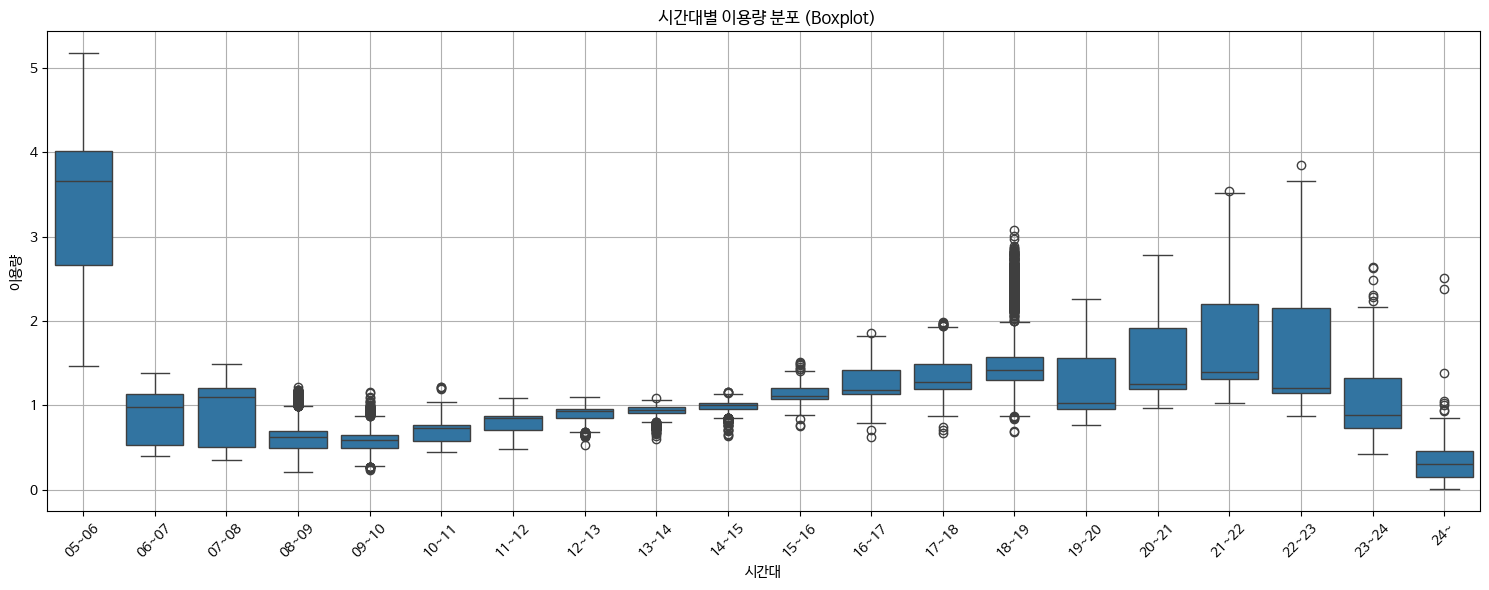

In [52]:
time_cols = [col for col in f_df.columns if '~' in col or col =='24~']

# melt로 long-format 변환
long_df = f_df.melt(
    id_vars=['날짜', '호선'],
    value_vars=time_cols,
    var_name='시간대',
    value_name='이용량'
)

# boxplot 그리기
plt.figure(figsize=(15, 6))
sns.boxplot(x='시간대', y='이용량', data=long_df)
plt.title("⏰ 시간대별 이용량 분포 (Boxplot)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### 기계학습7     
호선을 예측하는 분류 모델을 만들고 평가하라
- 평가데이터 : 일(day)이 4로 나눈 나머지가 1인 일자
- 학습데이터 : 그 외
- 평가지표 : f1_score (micro,macro 모두 확인)
- 2가지 이상 모델

In [ ]:
print('''
Micro F1-score
- 샘플 수에 따라 가중치, 불균형에 민감, 전체적인 예측 성능, 정확도가 중요한 경우
- 전체 성능 진단

Macro F1-score
- 클래스별 동일 가중(소수 클래스에 영향을 줌), 불균형에 덜 민감, 클래스별 고른 성능
- 클래스별 균형 확인 후 모델 개선이 목표
''')

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score

f_df['구분'] = f_df['날짜'].apply(lambda x : 'test' if x.day % 4 ==1 else 'train')

train_set = f_df[f_df['구분'] == 'train'].reset_index(drop= True)
X_train = train_set.drop(columns = ['날짜','호선','구분'])
y_train = train_set['호선']


test_set = f_df[f_df['구분'] == 'test'].reset_index(drop= True)
X_test = test_set.drop(columns = ['날짜','호선','구분'])
y_test = test_set['호선']


,Model,F1 Micro,F1 Macro
0,RF,1.000000,1.000000
1,SVC,0.993019,0.993019


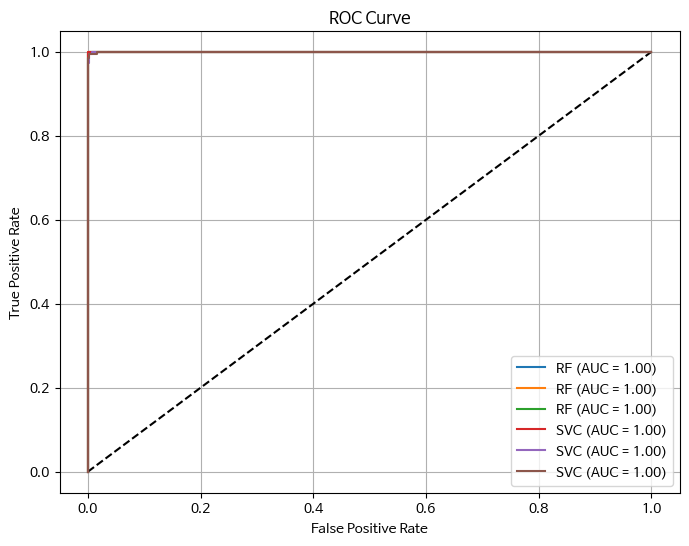

In [65]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def eval_modle(name, model, X_train, y_train, X_test, y_test) :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_micro = f1_score(y_test, pred, average = 'micro')
    f1_macro = f1_score(y_test, pred, average = 'macro')

    # Return the model for later use in AUC calculation and plotting
    return name, f1_micro, f1_macro, model

res = []
model_evaluations = []

for name, model in [['RF', RandomForestClassifier()] , ['SVC', SVC(probability= True)]] :
    name, f1_micro, f1_macro, trained_model = eval_modle(name, model, X_train, y_train, X_test, y_test)
    res.append([name, f1_micro, f1_macro])
    model_evaluations.append({'name': name, 'model': trained_model, 'f1_micro': f1_micro, 'f1_macro': f1_macro})


# Display F1 scores
display(pd.DataFrame(res, columns=['Model', 'F1 Micro', 'F1 Macro']))

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot([0,1],[0,1], 'k--') # Plot random guess line

y_bin = label_binarize(y_test, classes = np.unique(y_test))

for eval_data in model_evaluations:
    model = eval_data['model']
    name = eval_data['name']
    pred_proba = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{name} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 통계 (40점)

### 통계1      
한 카페에서는 고객들이 음료를 주문한 후, 음료가 준비되는 시간을 추적한다.      
음료 준비 시간은 평균이 5분이고, 표준편차가 1.5분인 정규분포를 따른다.         

1) 특정 고객이 음료를 6분 이내에 받을 확률은?     
2) 3분에서 7분 사이에 음료가 준비될 확률은?   
3) 10명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률은?

In [75]:
from scipy.stats import norm, binom

mean = 5
sd = 1.5
rv = norm(mean, sd)

# 1. 6분이내
prob1 = rv.cdf(6)
print(f"6분 이내 받을 확률 {prob1:.4f}")

# 2. 3분, 7분 사이
prob2 = rv.cdf(7) - rv.cdf(3)
print(f"3분, 7분 사이 :{prob2:.4f}")

# 10명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률
n = 10
print(f"0명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률 :{(1 - binom.cdf(2, n, prob1)):.4f}")

6분 이내 받을 확률 0.7475
3분, 7분 사이 :0.8176
0명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률 :0.9996


### 통계2
한 레스토랑에서 두 명의 셰프(A와 B)가 준비한 요리에 대한 고객들의 만족도를 조사했다.     
각 셰프가 준비한 요리에 대해 10명의 고객이 점수를 매겼다. 점수는 1점부터 10점까지이며, 점수가 높을수록 만족도가 높음을 의미한다.     
두 셰프의 요리에 대한 고객 점수가 정규분포를 따르지 않는다고 가정하고, 셰프 A와 셰프 B의 요리에 대해 고객들의 만족도가 차이가 나는지 비모수 검정을 통해 확인하라.     

셰프 A의 고객 점수:
7,8,9,5,6,7,8,6,7,9

셰프 B의 고객 점수:
6,5,8,7,6,5,6,4,7,5

(1) 가설설정     
(2) 통계검정

In [ ]:
print('''
Wilcoxon [대응표본]
- 같은 10명이 A. B 전부 평가한 경우
- 하나의 측정자가 두 조건을 비교

Mann-Whitney [독립 표본]
- A 측정자, B 측정자가 다름
- 예) 남성, 여성의 그룹 시험 점수를 비교
''')

In [77]:
from scipy.stats import wilcoxon

a = [7,8,9,5,6,7,8,6,7,9]
b = [6,5,8,7,6,5,6,4,7,5]

# wilcoxon
stat, p_value = wilcoxon(a, b)

print(f"wilcoxon U statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("결론: 유의수준 0.05에서 귀무가설을 기각합니다. 두 셰프의 요리에 대한 고객 만족도에 유의미한 차이가 있습니다.")
else:
    print("결론: 유의수준 0.05에서 귀무가설을 채택합니다. 두 셰프의 요리에 대한 고객 만족도에 유의미한 차이가 없습니다.")

wilcoxon U statistic: 4.5000
P-value: 0.0625
결론: 유의수준 0.05에서 귀무가설을 채택합니다. 두 셰프의 요리에 대한 고객 만족도에 유의미한 차이가 없습니다.


### 통계3       
병원에서 특정 질병의 진단을 위해 두 가지 서로 다른 검사 (검사 X, 검사 Y)를 시행한다. 검사 X와 Y는 서로 독립적이며 각각 다른 진단 결과를 제공한다.    


- 전체 인구에서 질병을 가진 사람의 비율: 2%
- 질병이 없는 사람의 비율: 98%
- 질병이 있는 경우 검사 X가 양성일 확률: 73%
- 질병이 없는 경우 검사 X가 양성일 확률: 10%
- 질병이 있는 경우 검사 Y가 양성일 확률: 66%
- 질병이 없는 경우 검사 Y가 양성일 확률: 5%


1. 검사 X와 검사 Y 모두 양성일 때, 환자가 실제로 질병을 가질 확률은 얼마인가?
2. 검사 X가 양성이고 검사 Y가 음성일 때, 환자가 실제로 질병을 가질 확률은 얼마인가?
3. 검사 Y가 양성일 때, 검사 X가 음성일 확률은?

In [90]:
do = 0.02
dx = 0.98

# X가 양성
do_xpositive = 0.73
dx_xpositive = 0.1

# Y가 양성
do_ypositive = 0.66
dx_ypositive = 0.05

In [92]:
# 검사 X와 검사 Y 모두 양성일 때, 환자가 실제로 질병을 가질 확률은 얼마
# P(Disease | X+ & Y+)

# 질병이 있을때의 X, Y양성
do_both_positive = do_xpositive * do_ypositive

# 질병이 없을 떄의 X, Y양성
dx_both_positive = dx_xpositive * dx_ypositive

# 전체 양성
total_positive = 0.02 * do_both_positive +  dx_both_positive * 0.98

# 베이즈 정리
(do_both_positive * 0.02) / total_positive


0.662905888827738

In [95]:
# 검사 X가 양성이고 검사 Y가 음성일 때, 환자가 실제로 질병을 가질 확률은 얼마
# P(Disease| X+ & Y-)

# 질병이 있을때, X가 양성 & Y가 음성인 경우
do = do_xpositive * (1 - do_ypositive)

# 질병이 없을떄, X가 양성 & Y가 음성인 경우
dx = dx_xpositive * (1 - dx_ypositive)

# 전체 확률
total = do * 0.02 + dx * 0.98

# 베이지안 정리
(do * 0.02) / total

0.05062000326317507

In [100]:
# 검사 Y가 양성일 때, 검사 X가 음성일 확률은?
# P(X-| Y+) = P(X- ∩ Y+) / P(Y+)

# 질병이 있을때
# X가 음성이고, Y는 양성
dopo = (1 - do_xpositive) * do_ypositive
# 질병이 없을때
# X가 음성이고, Y는 양성
dxpo = (1- dx_xpositive) * dx_ypositive

total = dopo * 0.02 + dxpo * 0.98

# Y가 양성
ypositive = do_ypositive * 0.02 + dx_ypositive * 0.98

# 조건부 확률
total / ypositive

0.7663022508038585